In [42]:
import sys
sys.path.append('../src')
from data_manager import *

import os
from time import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import loguniform

import cv2
from skimage.feature import hog

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.decomposition import PCA

root_path = '../'

# Eigenfaces construction using CK+48

### Data

In [2]:
ck_data_path = os.path.join(root_path, 'data/CK+48')
ck_data_path

image_files = list(get_image_paths(ck_data_path))

images = get_images(image_files)
labels = get_labels(image_files, 'ck')

print(f"Dataset length: {len(image_files)}")
print(f"Image shape: {images[0].shape}")

100%|██████████| 981/981 [00:17<00:00, 55.48it/s]

Dataset length: 981
Image shape: (48, 48)


In [25]:
n, h, w = images.shape
X = images.reshape((n, h*w))
# print(X.shape) 
# # (981, 2304)
# print(X[:3])
# # [[ 24  10  13 ... 150 153 156]
# #  [ 17  10  16 ... 151 153 156]
# #  [ 27  13  10 ... 148 152 156]]

y = labels
# print(y.shape) 
# # (981,)
# print(y[:3])
# # ['Anger' 'Anger' 'Anger']
# np.unique(y)
# # array(['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness',
# #        'Surprise'])
# len(np.unique(y))
# # 7

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)
print(y_train[:3])

['Anger' 'Fear' 'Disgust']


In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
n_components = 200

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Extracting the top 200 eigenfaces from 735 faces
Projecting the input data on the eigenfaces orthonormal basis


In [39]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 3.727s
Best estimator found by grid search:
SVC(C=1148.1174135002288, class_weight='balanced', gamma=0.00030036984068576583)


Predicting people's names on the test set
done in 0.028s
              precision    recall  f1-score   support

       Anger       0.97      1.00      0.99        35
     Disgust       1.00      1.00      1.00        53
        Fear       1.00      1.00      1.00        17
   Happiness       1.00      1.00      1.00        55
     Neutral       1.00      1.00      1.00         9
     Sadness       1.00      0.95      0.97        20
    Surprise       1.00      1.00      1.00        57

    accuracy                           1.00       246
   macro avg       1.00      0.99      0.99       246
weighted avg       1.00      1.00      1.00       246



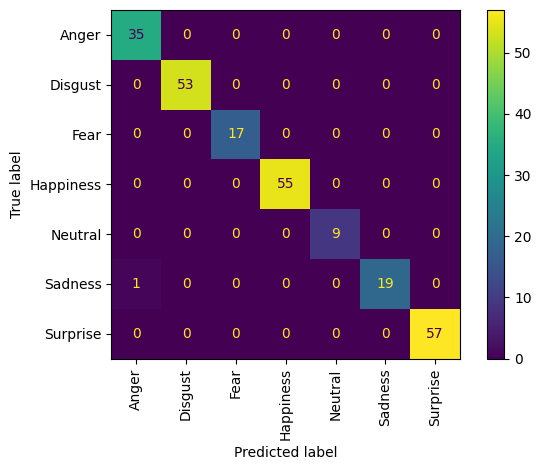

In [43]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

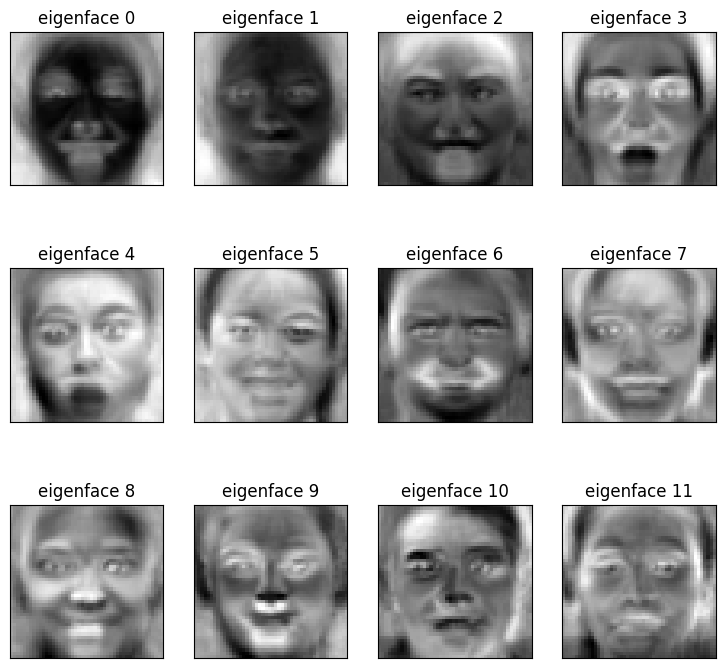

In [44]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [31]:
svm_clf = SVC(
    kernel='rbf',
    gamma='scale',
    C= 10
)
svm_clf = svm_clf.fit(X_train_pca, y_train)

In [ ]:
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def load_data():
    # Load your facial emotion dataset, where X contains images and y contains corresponding labels.
    # You may need to preprocess your dataset according to your requirements.
    # For example, use OpenCV to read images and resize them to a standard size.

    # Replace the following lines with your actual data loading code.
    X = np.random.randn(100, 100, 100, 3)  # Placeholder for images
    y = np.random.randint(0, 2, 100)  # Placeholder for labels

    return X, y

def extract_eigenfaces(X):
    # Flatten each image into a 1D vector.
    X_flat = X.reshape((X.shape[0], -1))

    # Perform Principal Component Analysis (PCA) to extract eigenfaces.
    pca = PCA(n_components=50)  # Adjust the number of components as needed.
    eigenfaces = pca.fit_transform(X_flat)

    return eigenfaces

def train_svm(X_train, y_train):
    # Train an SVM classifier.
    svm_classifier = SVC(kernel='linear')  # You can adjust the kernel and other parameters.
    svm_classifier.fit(X_train, y_train)

    return svm_classifier

def main():
    # Load data
    X, y = load_data()

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Extract eigenfaces from training data
    eigenfaces_train = extract_eigenfaces(X_train)

    # Train SVM using eigenfaces as features
    svm_classifier = train_svm(eigenfaces_train, y_train)

    # Extract eigenfaces from testing data
    eigenfaces_test = extract_eigenfaces(X_test)

    # Predict using the trained SVM
    y_pred = svm_classifier.predict(eigenfaces_test)

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

if __name__ == "__main__":
    main()


# HOW TO CHOOSE NUMBER OF FEATURES

### cumulative variance
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA().fit(X)
explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.plot(explained_variance_ratio_cumsum)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

### elbow method
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()



# gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'n_components': [5, 10, 20, 30, 50]}
pca = PCA()
grid_search = GridSearchCV(pca, param_grid=param_grid, cv=5)
grid_search.fit(X)
best_n_components = grid_search.best_params_['n_components']

